<a href="https://colab.research.google.com/github/WhiteTeaDragon/SingularValues/blob/main/Timing_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf

k = 3
n = 16
x_axis = sorted(set(np.around(np.logspace(0, 3, dtype=int))))

In [ ]:
# strided_method from https://stackoverflow.com/questions/43735034/create-a-matrix-from-a-vector-where-each-row-is-a-shifted-version-of-the-vector
def strided_method(ar):
    a = np.concatenate((ar[1:], ar))
    L = len(ar)
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a[L-1:], (L,L), (-n,n)).copy()

def strided_method_for_matrices(arr):
    a = np.concatenate((arr[1:], arr))
    L = len(arr)
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a[L-1:], (L, L, *(arr[0].shape)), (-n,n, *(a.strides[1:])))

def build_doubly_block_circ_matrix(k, n, kernel2d):
    padded_kernel = np.pad(kernel2d, [(0, n - k), (0, n - k)], mode='constant')
    arr = [0] * n
    for i in range(n):
        arr[i] = strided_method(padded_kernel[i])
    return strided_method_for_matrices(arr).transpose(0, 2, 1, 3).reshape(-1, n**2)

def build_matrix(k, n, m, kernel):
    dbc_matrices = [[0] * m for i in range(m)]
    for i in range(m):
        for j in range(m):
            dbc_matrices[i][j] = build_doubly_block_circ_matrix(k, n, kernel[:, :, i, j])
    return np.block(dbc_matrices)

In [ ]:
import time

def test_singular_method(filename, x_axis, k, n, method,
                         is_full_matr_needed=False, is_tensorflow=False):
    file_timestamps = open(filename, "w")
    file_timestamps.close()
    timestamps_means = []
    timestamps_vars = []
    for m in x_axis:
        print("Starting with", m)
        curr_times = []
        for i in range(3):
            kernel = np.random.standard_normal(size=(k, k, m, m))
            if is_full_matr_needed:
                matr = build_matrix(k, n, m, kernel)
            else:
                matr = None
            start = time.time()
            s = method(matr, kernel, n)
            total = time.time() - start
            curr_times.append(total)
            if total >= 500:
                break
        curr_times = np.array(curr_times)
        curr_mean = curr_times.mean()
        curr_var = curr_times.var()
        file_timestamps = open(filename, "a")
        print(curr_mean, curr_var, file=file_timestamps)
        file_timestamps.close()
        timestamps_means.append(curr_mean)
        timestamps_vars.append(curr_var)
        print("Finishing with", m)
        print("Mean time", timestamps_means[-1])
        if total >= 500:
            break
    return timestamps_means, timestamps_vars

In [ ]:
def simple_method(matr, kernel, n):
    return np.linalg.svd(matr, compute_uv=False)

def numpy_method(matr, kernel, n):
    transforms = np.fft.fft2(kernel, (n, n), axes=[0, 1])
    return np.linalg.svd(transforms, compute_uv=False)

def tensorflow_method128(matr, kernel, n):
    transforms = tf.transpose(
        tf.signal.fft2d(
            tf.transpose(
                tf.pad(
                    kernel + 0j, ((0, n - kernel.shape[0]),
                                  (0, n - kernel.shape[0]), (0, 0), (0, 0))
                ),
                perm=[2, 3, 0, 1]
            )
        ), 
        perm=[2, 3, 0, 1]
    )
    return tf.linalg.svd(transforms, compute_uv=False)

def tensorflow_method64(matr, kernel, n):
    conv_tr = tf.cast(tf.transpose(kernel, perm=[2, 3, 0, 1]), tf.complex64)
    transforms = tf.transpose(
        tf.signal.fft2d(
            tf.pad(
                conv_tr, ((0, 0), (0, 0), (0, n - kernel.shape[0]),
                                (0, n - kernel.shape[0]))
            )
        ), 
        perm=[2, 3, 0, 1]
    )
    return tf.linalg.svd(transforms, compute_uv=False)

In [ ]:
timestamps_means_numpy_bruteforce, timestamps_vars_numpy_bruteforce = test_singular_method(
    "bruteforce_mean_var.txt", x_axis, k, n, simple_method, True)

Starting with 1
Finishing with 1
Mean time 0.014531771341959635
Starting with 2
Finishing with 2
Mean time 0.06328582763671875
Starting with 3
Finishing with 3
Mean time 0.19745326042175293
Starting with 4
Finishing with 4
Mean time 0.4291853904724121
Starting with 5
Finishing with 5
Mean time 0.7718914349873861
Starting with 6
Finishing with 6
Mean time 1.3097848892211914
Starting with 7
Finishing with 7
Mean time 1.981634537378947
Starting with 8
Finishing with 8
Mean time 2.8922599951426187
Starting with 9
Finishing with 9
Mean time 4.055916945139567
Starting with 10
Finishing with 10
Mean time 5.837780872980754
Starting with 12
Finishing with 12
Mean time 10.652106444040934
Starting with 14
Finishing with 14
Mean time 18.01745104789734
Starting with 16
Finishing with 16
Mean time 30.438575903574627
Starting with 19
Finishing with 19
Mean time 48.98483602205912
Starting with 22
Finishing with 22
Mean time 80.01836347579956
Starting with 25
Finishing with 25
Mean time 121.06005342801

In [ ]:
timestamps_means_fft_numpy, timestamps_vars_fft_numpy = test_singular_method(
    "fft_numpy_mean_var.txt", x_axis, k, n, numpy_method)

Starting with 1
Finishing with 1
Mean time 0.0024177233378092446
Starting with 2
Finishing with 2
Mean time 0.0010921160380045574
Starting with 3
Finishing with 3
Mean time 0.0012856324513753254
Starting with 4
Finishing with 4
Mean time 0.0014664332071940105
Starting with 5
Finishing with 5
Mean time 0.002059459686279297
Starting with 6
Finishing with 6
Mean time 0.0027550061543782554
Starting with 7
Finishing with 7
Mean time 0.003318309783935547
Starting with 8
Finishing with 8
Mean time 0.004224697748819987
Starting with 9
Finishing with 9
Mean time 0.004398266474405925
Starting with 10
Finishing with 10
Mean time 0.00483854611714681
Starting with 12
Finishing with 12
Mean time 0.006715218226114909
Starting with 14
Finishing with 14
Mean time 0.008565107981363932
Starting with 16
Finishing with 16
Mean time 0.010858933130900065
Starting with 19
Finishing with 19
Mean time 0.016884644826253254
Starting with 22
Finishing with 22
Mean time 0.01900633176167806
Starting with 25
Finishin

In [ ]:
timestamps_means_fft_tensorflow, timestamps_vars_fft_tensorflow = test_singular_method(
    "fft_tensorflow64_mean_var.txt", x_axis, k, n, tensorflow_method64)

Starting with 1
Finishing with 1
Mean time 0.0025048255920410156
Starting with 2
Finishing with 2
Mean time 0.0016807715098063152
Starting with 3
Finishing with 3
Mean time 0.0028263727823893228
Starting with 4
Finishing with 4
Mean time 0.004540443420410156
Starting with 5
Finishing with 5
Mean time 0.005471706390380859
Starting with 6
Finishing with 6
Mean time 0.009160200754801432
Starting with 7
Finishing with 7
Mean time 0.010860681533813477
Starting with 8
Finishing with 8
Mean time 0.014215548833211264
Starting with 9
Finishing with 9
Mean time 0.021306912104288738
Starting with 10
Finishing with 10
Mean time 0.027716398239135742
Starting with 12
Finishing with 12
Mean time 0.044975598653157554
Starting with 14
Finishing with 14
Mean time 0.07102799415588379
Starting with 16
Finishing with 16
Mean time 0.013701518376668295
Starting with 19
Finishing with 19
Mean time 0.017434994379679363
Starting with 22
Finishing with 22
Mean time 0.024453004201253254
Starting with 25
Finishing

In [ ]:
timestamps_means_fft_tensorflow, timestamps_vars_fft_tensorflow = test_singular_method(
    "fft_tensorflow128_mean_var.txt", x_axis, k, n, tensorflow_method128)

Starting with 1
Finishing with 1
Mean time 0.0032776991526285806
Starting with 2
Finishing with 2
Mean time 0.0016402403513590496
Starting with 3
Finishing with 3
Mean time 0.0023981730143229165
Starting with 4
Finishing with 4
Mean time 0.0038696924845377603
Starting with 5
Finishing with 5
Mean time 0.005202293395996094
Starting with 6
Finishing with 6
Mean time 0.007432381312052409
Starting with 7
Finishing with 7
Mean time 0.010816574096679688
Starting with 8
Finishing with 8
Mean time 0.015132268269856771
Starting with 9
Finishing with 9
Mean time 0.02162512143452962
Starting with 10
Finishing with 10
Mean time 0.02737005551656087
Starting with 12
Finishing with 12
Mean time 0.04737297693888346
Starting with 14
Finishing with 14
Mean time 0.07538684209187825
Starting with 16
Finishing with 16
Mean time 0.01722828547159831
Starting with 19
Finishing with 19
Mean time 0.022524595260620117
Starting with 22
Finishing with 22
Mean time 0.03429094950358073
Starting with 25
Finishing wit

In [ ]:
def read_from_file(filename):
    file_r = open(filename, "r")
    timestamps_means, timestamps_stds = [], []
    for line in file_r:
        mean, var = list(map(float, line.split()))
        timestamps_means.append(mean)
        timestamps_stds.append(np.sqrt(var))
    return np.array(timestamps_means), np.array(timestamps_stds)

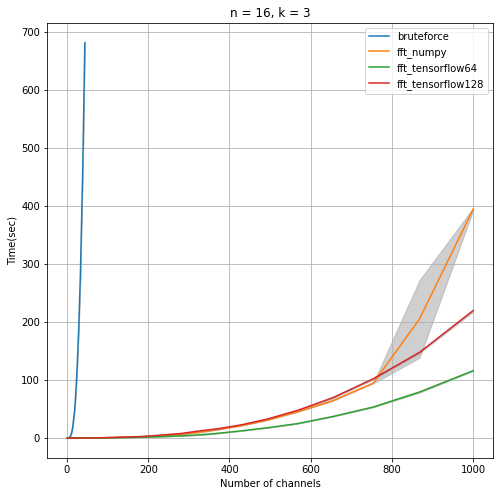

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
for filename in ["bruteforce_mean_var.txt", "fft_numpy_mean_var.txt", "fft_tensorflow64_mean_var.txt",
                 "fft_tensorflow128_mean_var.txt"]:
    means, stds = read_from_file(filename)
    ax.plot(x_axis[:means.shape[0]], means, label=filename[:-13])
    ax.fill_between(x_axis[:means.shape[0]], means + stds, means - stds, color='#888888', alpha=0.4)
ax.legend(loc='best')
ax.set_xlabel('Number of channels')
ax.set_ylabel('Time(sec)')
ax.set_title('n = 16, k = 3')
ax.grid(True)

In [ ]:
x_axis3 = sorted(set(np.around(np.linspace(700, 1000, 4, dtype=int))))
x_axis3

[700, 800, 900, 1000]

In [ ]:
timestamps_means_fft_tensorflow, timestamps_vars_fft_tensorflow = test_singular_method(
    "fft_tensorflow_on_high_m_mean_var.txt", x_axis3, k, n, tensorflow_method128)

Starting with 700
Finishing with 700
Mean time 80.91695769627889
Starting with 800
Finishing with 800
Mean time 120.05096133550008
Starting with 900
Finishing with 900
Mean time 165.86031540234885
Starting with 1000
Finishing with 1000
Mean time 223.1487508614858


In [ ]:
timestamps_means_fft_tensorflow, timestamps_vars_fft_tensorflow = test_singular_method(
    "fft_numpy_on_high_m_mean_var.txt", x_axis3, k, n, numpy_method)

Starting with 700
Finishing with 700
Mean time 76.50138449668884
Starting with 800
Finishing with 800
Mean time 110.47678033510844
Starting with 900
Finishing with 900
Mean time 151.34651017189026
Starting with 1000
Finishing with 1000
Mean time 207.95373558998108


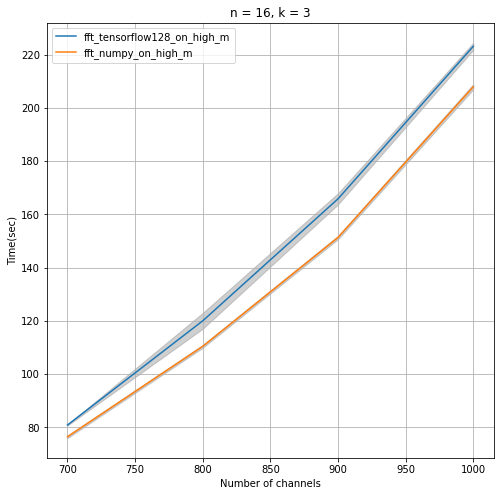

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
for filename in ["fft_tensorflow128_on_high_m_mean_var.txt", "fft_numpy_on_high_m_mean_var.txt"]:
    means, stds = read_from_file(filename)
    ax.plot(x_axis3[:means.shape[0]], means, label=filename[:-13])
    ax.fill_between(x_axis3[:means.shape[0]], means + stds, means - stds, color='#888888', alpha=0.4)
ax.legend(loc='best')
ax.set_xlabel('Number of channels')
ax.set_ylabel('Time(sec)')
ax.set_title('n = 16, k = 3')
ax.grid(True)

In [ ]:
k2 = 11
n2 = 64
x_axis2 = sorted(set(np.around(np.logspace(0, 2.4, dtype=int))))

In [ ]:
timestamps_means_numpy_bruteforce, timestamps_vars_numpy_bruteforce = test_singular_method(
    "bruteforce_mean_var_k11_n64.txt", x_axis2, k2, n2, simple_method, True)

Starting with 1
Finishing with 1
Mean time 29.771438757578533
Starting with 2
Finishing with 2
Mean time 257.5141364733378
Starting with 3
Finishing with 3
Mean time 872.346272945404


In [ ]:
timestamps_means_numpy_bruteforce, timestamps_vars_numpy_bruteforce = test_singular_method(
    "fft_numpy_mean_var_k11_n64.txt", x_axis2, k2, n2, numpy_method)

Starting with 1
Finishing with 1
Mean time 0.004894574483235677
Starting with 2
Finishing with 2
Mean time 0.0061524709065755205
Starting with 3
Finishing with 3
Mean time 0.01259001096089681
Starting with 4
Finishing with 4
Mean time 0.017431894938151043
Starting with 5
Finishing with 5
Mean time 0.023718913396199543
Starting with 6
Finishing with 6
Mean time 0.03300309181213379
Starting with 7
Finishing with 7
Mean time 0.04112704594930013
Starting with 8
Finishing with 8
Mean time 0.051168203353881836
Starting with 9
Finishing with 9
Mean time 0.0620877742767334
Starting with 10
Finishing with 10
Mean time 0.07279801368713379
Starting with 11
Finishing with 11
Mean time 0.08389051755269368
Starting with 13
Finishing with 13
Mean time 0.11499532063802083
Starting with 14
Finishing with 14
Mean time 0.12868690490722656
Starting with 16
Finishing with 16
Mean time 0.1659086545308431
Starting with 18
Finishing with 18
Mean time 0.1991401513417562
Starting with 21
Finishing with 21
Mean 

In [ ]:
timestamps_means_numpy_bruteforce, timestamps_vars_numpy_bruteforce = test_singular_method(
    "fft_numpy_mean_var_k11_n64_m251.txt", [251], k2, n2, numpy_method)

Starting with 251
Finishing with 251
Mean time 73.2537800470988


In [ ]:
timestamps_means, timestamps_vars = test_singular_method(
    "fft_tensorflow64_mean_var_k11_n64.txt", x_axis2, k2, n2, tensorflow_method64)

Starting with 1
Finishing with 1
Mean time 0.008306503295898438
Starting with 2
Finishing with 2
Mean time 0.005358298619588216
Starting with 3
Finishing with 3
Mean time 0.014208634694417318
Starting with 4
Finishing with 4
Mean time 0.029352108637491863
Starting with 5
Finishing with 5
Mean time 0.05867830912272135
Starting with 6
Finishing with 6
Mean time 0.09679285685221355
Starting with 7
Finishing with 7
Mean time 0.15642650922139487
Starting with 8
Finishing with 8
Mean time 0.21923200289408365
Starting with 9
Finishing with 9
Mean time 0.31006987889607746
Starting with 10
Finishing with 10
Mean time 0.4289549191792806
Starting with 11
Finishing with 11
Mean time 0.5586617787679037
Starting with 13
Finishing with 13
Mean time 0.9158399899800619
Starting with 14
Finishing with 14
Mean time 1.119226296742757
Starting with 16
Finishing with 16
Mean time 0.2097031275431315
Starting with 18
Finishing with 18
Mean time 0.24926996231079102
Starting with 21
Finishing with 21
Mean time 

In [ ]:
timestamps_means, timestamps_vars = test_singular_method(
    "fft_tensorflow128_mean_var_k11_n64.txt", x_axis2, k2, n2, tensorflow_method128)

Starting with 1
Finishing with 1
Mean time 0.004383246103922526
Starting with 2
Finishing with 2
Mean time 0.004320303599039714
Starting with 3
Finishing with 3
Mean time 0.013892332712809244
Starting with 4
Finishing with 4
Mean time 0.030980428059895832
Starting with 5
Finishing with 5
Mean time 0.05966790517171224
Starting with 6
Finishing with 6
Mean time 0.09936936696370442
Starting with 7
Finishing with 7
Mean time 0.15620764096577963
Starting with 8
Finishing with 8
Mean time 0.22613374392191568
Starting with 9
Finishing with 9
Mean time 0.317272424697876
Starting with 10
Finishing with 10
Mean time 0.4330844084421794
Starting with 11
Finishing with 11
Mean time 0.5624648729960123
Starting with 13
Finishing with 13
Mean time 0.9761740366617838
Starting with 14
Finishing with 14
Mean time 1.1700187524159749
Starting with 16
Finishing with 16
Mean time 0.2523529529571533
Starting with 18
Finishing with 18
Mean time 0.32651154200236004
Starting with 21
Finishing with 21
Mean time 0

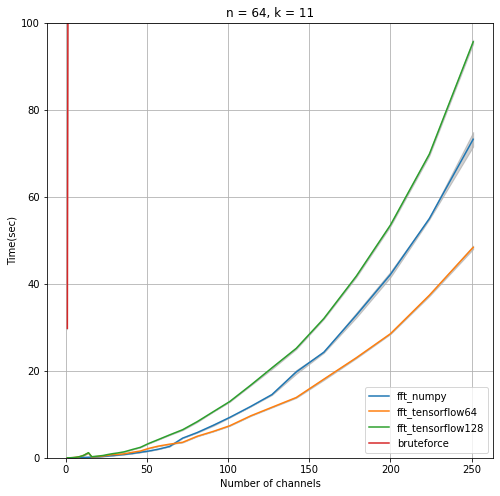

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
for filename in ["fft_numpy_mean_var_k11_n64.txt", "fft_tensorflow64_mean_var_k11_n64.txt",
                 "fft_tensorflow128_mean_var_k11_n64.txt", "bruteforce_mean_var_k11_n64.txt"]:
    means, stds = read_from_file(filename)
    ax.plot(x_axis2[:means.shape[0]], means, label=filename[:-21])
    ax.fill_between(x_axis2[:means.shape[0]], means + stds, means - stds, color='#888888', alpha=0.4)
ax.legend(loc='best')
ax.set_xlabel('Number of channels')
ax.set_ylabel('Time(sec)')
ax.set_title('n = 64, k = 11')
ax.set_ylim(0, 100)
ax.grid(True)